## Шаг 0. Установка библиотек

In [3]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Шаг 1. Загрузка данных

### Скачиваем датасет [InstaCart Online Grocery Basket Analysis Dataset](https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset/data)

In [4]:
# Настройка прав доступа 
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle datasets download -d "yasserh/instacart-online-grocery-basket-analysis-dataset"

Dataset URL: https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset
License(s): CC0-1.0
  0%|                                                | 0.00/197M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 197M/197M [00:00<00:00, 2.80GB/s]


In [2]:
!unzip instacart-online-grocery-basket-analysis-dataset.zip
!rm instacart-online-grocery-basket-analysis-dataset.zip

Archive:  instacart-online-grocery-basket-analysis-dataset.zip
  inflating: aisles.csv              
  inflating: departments.csv         
  inflating: order_products__prior.csv  
  inflating: order_products__train.csv  
  inflating: orders.csv              
  inflating: products.csv            


## Шаг 2. EDA

### Датасеты в переменные

In [3]:
import os
import pandas as pd

csv_files = [f for f in os.listdir() if f.endswith('.csv')]

for file in csv_files:
    var_name = file[:-4]  # Удаляем .csv
    globals()[var_name] = pd.read_csv(file)
    print(f'Файл {file} загружен в переменную {var_name}')

Файл order_products__prior.csv загружен в переменную order_products__prior
Файл products.csv загружен в переменную products
Файл orders.csv загружен в переменную orders
Файл order_products__train.csv загружен в переменную order_products__train
Файл aisles.csv загружен в переменную aisles
Файл departments.csv загружен в переменную departments


### Смотрим на таблицы

In [2]:
from tabulate import tabulate

print('order_products__prior \n')
print(tabulate(order_products__prior.head(), headers='keys', tablefmt='pipe', showindex=False))
print('products \n')
print(tabulate(products.head(), headers='keys', tablefmt='pipe', showindex=False))
print('orders \n')
print(tabulate(orders.head(), headers='keys', tablefmt='pipe', showindex=False))
print('order_products__train \n')
print(tabulate(order_products__train.head(), headers='keys', tablefmt='pipe', showindex=False))
print('aisles \n')
print(tabulate(aisles.head(), headers='keys', tablefmt='pipe', showindex=False))
print('departments \n')
print(tabulate(departments.head(), headers='keys', tablefmt='pipe', showindex=False))

order_products__prior 

|   order_id |   product_id |   add_to_cart_order |   reordered |
|-----------:|-------------:|--------------------:|------------:|
|          2 |        33120 |                   1 |           1 |
|          2 |        28985 |                   2 |           1 |
|          2 |         9327 |                   3 |           0 |
|          2 |        45918 |                   4 |           1 |
|          2 |        30035 |                   5 |           0 |
products 

|   product_id | product_name                                                      |   aisle_id |   department_id |
|-------------:|:------------------------------------------------------------------|-----------:|----------------:|
|            1 | Chocolate Sandwich Cookies                                        |         61 |              19 |
|            2 | All-Seasons Salt                                                  |        104 |              13 |
|            3 | Robust Golden Unsweete

**Таблицы и их поля:**

1. **order_products__prior**  
   - `order_id`: ID заказа.  
   - `product_id`: ID товара.  
   - `add_to_cart_order`: Порядок добавления товара в корзину
   - `reordered`: Флаг (1/0), был ли товар перезаказан (ранее покупался пользователем)

2. **order_products__train**  
   - Аналогична **order_products__prior**, но для обучающего набора данных

3. **products**  
   - `product_id`: ID товара
   - `product_name`: Название товара.  
   - `aisle_id`: ID категории товара (связь с таблицей *aisles*)
   - `department_id`: ID отдела (связь с таблицей *departments*)

4. **orders**  
   - `order_id`: ID заказа
   - `user_id`: ID пользователя
   - `eval_set`: Тип набора данных (prior/train/test)
   - `order_number`: Порядковый номер заказа пользователя
   - `order_dow`: День недели оформления заказа (0-6)
   - `order_hour_of_day`: Час оформления заказа (0-23) 
   - `days_since_prior_order`: Дней с момента предыдущего заказа (NaN для первого заказа) 

 
5. **aisles**  
   - `aisle_id`: ID категории товаров
   - `aisle`: Название категории

6. **departments**  
   - `department_id`: ID отдела.  
   - `department`: Название отдела (например, "замороженные продукты")

---

**Связи:**  
- `products.aisle_id` → `aisles.aisle_id`  
- `products.department_id` → `departments.department_id`  
- `order_products__prior/order_products__train.product_id` → `products.product_id`  
- `order_products__prior/order_products__train.order_id` → `orders.order_id`

### Первичный анализ

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Предварительный анализ структуры данных
def print_basic_stats(df, name):
    print(f"\n{name}:")
    print(f"Строки: {df.shape[0]}, Колонки: {df.shape[1]}")
    print("Пример данных:")
    display(df.head(2))
    print("\nПропуски:")
    print(df.isnull().sum())
    print("\nДубликаты:", df.duplicated().sum())

print_basic_stats(orders, 'Orders')
print_basic_stats(products, 'Products')
print_basic_stats(order_products__prior, 'Order Products Prior')
print_basic_stats(order_products__train, 'Order Products Train')


Orders:
Строки: 3421083, Колонки: 7
Пример данных:


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0



Пропуски:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Дубликаты: 0

Products:
Строки: 49688, Колонки: 4
Пример данных:


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13



Пропуски:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Дубликаты: 0

Order Products Prior:
Строки: 32434489, Колонки: 4
Пример данных:


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1



Пропуски:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Дубликаты: 0

Order Products Train:
Строки: 1384617, Колонки: 4
Пример данных:


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1



Пропуски:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Дубликаты: 0


### Визуализация

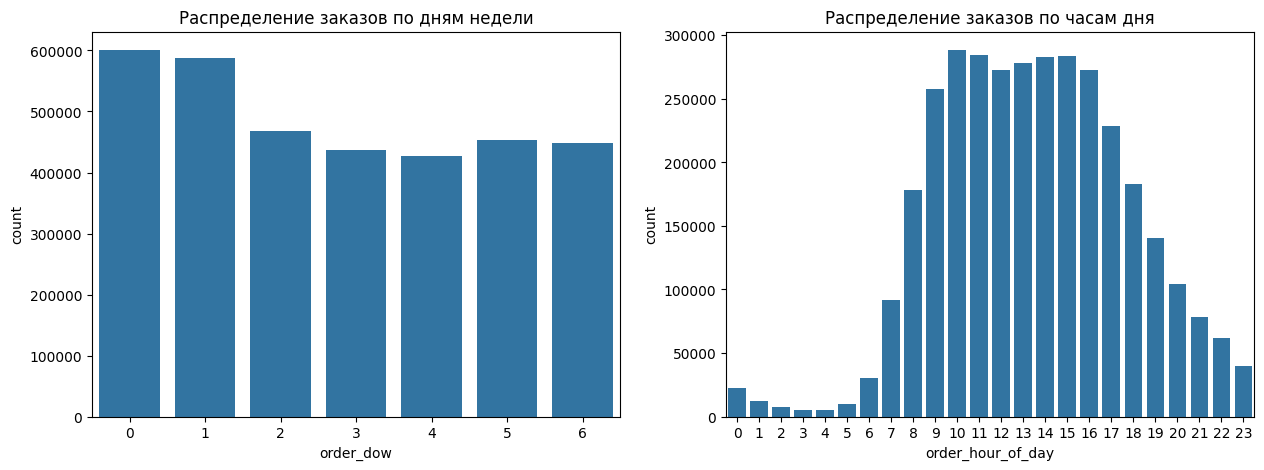

In [42]:
# 2. Анализ заказов (orders)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='order_dow', data=orders)
plt.title('Распределение заказов по дням недели')

plt.subplot(1, 2, 2)
sns.countplot(x='order_hour_of_day', data=orders)
plt.title('Распределение заказов по часам дня')
plt.show()

Text(0.5, 0, 'Дней')

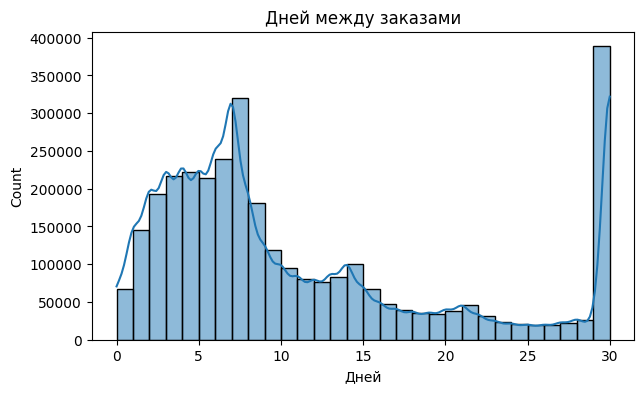

In [41]:
plt.figure(figsize=(7, 4))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=True)
plt.title('Дней между заказами')
plt.xlabel('Дней')

Text(0.5, 1.0, 'Топ-10 товаров')

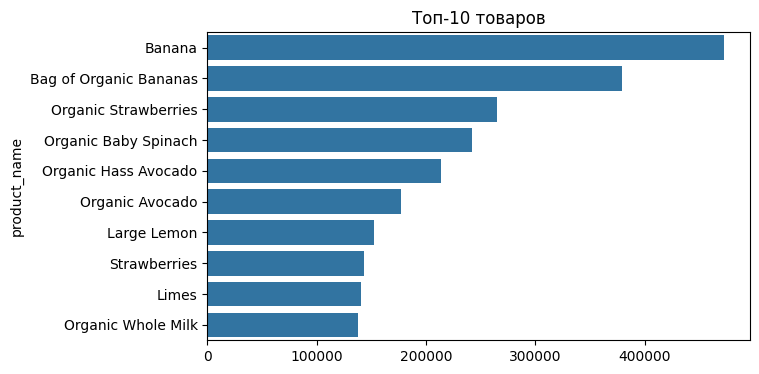

In [40]:
# 3. Анализ товаров в заказах
# Объединим данные о товарах с информацией о продуктах
full_prior = order_products__prior.merge(products, on='product_id').merge(aisles, on='aisle_id').merge(departments, on='department_id')

# Топ-10 самых популярных товаров
top_products = full_prior['product_name'].value_counts().head(10)
plt.figure(figsize=(7, 4))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Топ-10 товаров')

Text(0.5, 0, '% Reordered')

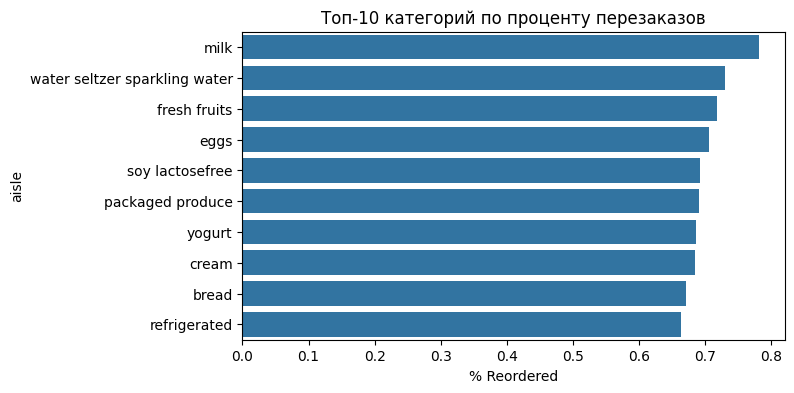

In [39]:
reorder_by_aisle = full_prior.groupby('aisle')['reordered'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(7, 4))
sns.barplot(x=reorder_by_aisle.values, y=reorder_by_aisle.index)
plt.title('Топ-10 категорий по проценту перезаказов')
plt.xlabel('% Reordered')

In [33]:
# 5. Анализ пользователей
user_analysis = orders.groupby('user_id').agg({
    'order_id': 'nunique',
    'days_since_prior_order': ['mean', 'max']
}).rename(columns={'order_id': 'total_orders'})

Text(0.5, 1.0, 'Распределение количества заказов на пользователя')

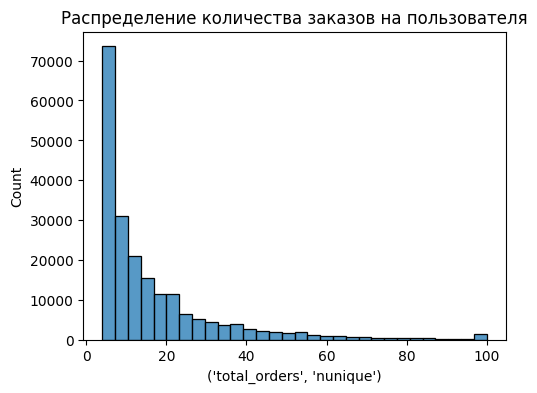

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(user_analysis[('total_orders', 'nunique')], bins=30)
plt.title('Распределение количества заказов на пользователя')

### Формируем датасеты

In [4]:
import pandas as pd
import numpy as np

# ==============================================================
# 1. Разделение заказов (orders) на prior/train/test
# ==============================================================
prior_orders = orders[orders['eval_set'] == 'prior']
train_orders = orders[orders['eval_set'] == 'train']
test_orders = orders[orders['eval_set'] == 'test']

# ==============================================================
# 2. Объединение с товарами для каждого набора отдельно
# ==============================================================
def merge_orders_with_products(orders_df, products_df, dataset_type):
    # Выбираем соответствующие товары (prior/train)
    if dataset_type == 'prior':
        order_products = order_products__prior
    elif dataset_type == 'train':
        order_products = order_products__train
    else:
        return None 

    # Соединяем заказы с товарами
    merged = orders_df.merge(
        order_products,
        on='order_id',
        how='inner'
    )
    
    # Добавляем информацию о продуктах, отделах и категориях
    merged = merged.merge(products, on='product_id', how='left')
    merged = merged.merge(aisles, on='aisle_id', how='left')
    merged = merged.merge(departments, on='department_id', how='left')
    
    # Удаляем ненужное поле
    merged = merged.drop('eval_set', axis=1)
    return merged

# Обрабатываем каждый набор
prior_data = merge_orders_with_products(prior_orders, order_products__prior, 'prior')
train_data = merge_orders_with_products(train_orders, order_products__train, 'train')
test_data = test_orders.drop('eval_set', axis=1)  # test без товаров

# ==============================================================
# 3. Проверка дубликатов (для каждого набора отдельно)
# ==============================================================
for name, data in [('Prior', prior_data), ('Train', train_data)]:
    duplicates = data.duplicated(subset=['order_id', 'product_id']).sum()
    print(f"Дубликаты в {name}: {duplicates}")

# ==============================================================
# Результат: отдельные датафреймы для ML
# ==============================================================
print("\nРазмеры данных:")
print(f"Prior: {prior_data.shape}")
print(f"Train: {train_data.shape}")
print(f"Test:  {test_data.shape}")

Дубликаты в Prior: 0
Дубликаты в Train: 0

Размеры данных:
Prior: (32434489, 14)
Train: (1384617, 14)
Test:  (75000, 6)


## Шаг 3. BaseLine

### Popularity-Based Recommendations

Метрики:
- precision@10: 0.0725
- recall@10: 0.0698
- hit_rate@10: 0.4584

In [5]:
import pandas as pd
import numpy as np

# 1. Формирование топа популярных товаров на основе prior_data
def get_popular_products(prior_data, top_n=10):
    # Считаем количество заказов, в которых был каждый товар
    product_popularity = prior_data.groupby('product_id')['order_id'].nunique().reset_index()
    product_popularity.columns = ['product_id', 'popularity_score']
    
    # Сортируем по популярности и берем топ-N
    top_products = product_popularity.sort_values('popularity_score', ascending=False).head(top_n)
    return top_products['product_id'].tolist()

# Топ-10 популярных товаров
top10_products = get_popular_products(prior_data, top_n=10)

In [15]:
# 2. Подготовка тестовых данных (используем train_data для оценки)
max_order_per_user = train_data.groupby('user_id')['order_number'].max().reset_index()
merged = train_data.merge(max_order_per_user, on=['user_id', 'order_number'])
test_data = merged.groupby('user_id')['product_id'].apply(list).reset_index()
test_data.columns = ['user_id', 'actual']

In [8]:
# 3. Генерация рекомендаций для всех пользователей
test_data['predicted'] = [top10_products] * len(test_data)

In [9]:
# 4. Расчет метрик
def calculate_metrics(test_data, all_products, top_n=10):
    # Precision@10, Recall@10, Hit Rate@10
    precisions = []
    recalls = []
    hits = []
    
    for _, row in test_data.iterrows():
        actual = set(row['actual'])
        predicted = set(row['predicted'][:top_n])
        
        # Совпадения
        common = actual & predicted
        
        # Precision: сколько из рекомендованных релевантны
        prec = len(common) / top_n if top_n > 0 else 0
        precisions.append(prec)
        
        # Recall: сколько релевантных найдено
        rec = len(common) / len(actual) if len(actual) > 0 else 0
        recalls.append(rec)
        
        # Hit Rate: был ли хотя бы один релевантный
        hits.append(1 if len(common) > 0 else 0)
    
    
    return {
        'precision@10': np.mean(precisions),
        'recall@10': np.mean(recalls),
        'hit_rate@10': np.mean(hits),
    }

In [11]:
# Уникальные товары в каталоге
all_products = prior_data['product_id'].unique()

# Расчет метрик
metrics = calculate_metrics(test_data, all_products)
print("\nОценка рекомендательной системы:")
print(f"Precision@10: {metrics['precision@10']:.4f}")
print(f"Recall@10:    {metrics['recall@10']:.4f}")
print(f"Hit Rate@10:  {metrics['hit_rate@10']:.4f}")


Оценка рекомендательной системы:
Precision@10: 0.0725
Recall@10:    0.0698
Hit Rate@10:  0.4584


### Коллаборативная фильтрация (Item-Based)
Метрики:
- precision@10: 0.0200
- recall@10: 0.0192
- hit_rate@10: 0.1624

In [17]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# 1. Подготовка данных
def prepare_data(prior_data, train_data):
    # Используем только пользователей из train_data
    train_user_ids = train_data['user_id'].unique()
    prior_filtered = prior_data[prior_data['user_id'].isin(train_user_ids)].copy()
    
    # Fallback: Топ популярных товаров
    global top_fallback
    top_fallback = prior_data['product_id'].value_counts().head(10).index.tolist()
    
    # Маппинги
    unique_users = np.unique(list(prior_filtered['user_id']) + list(train_data['user_id']))
    unique_products = prior_filtered['product_id'].unique()
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    product_to_idx = {product: idx for idx, product in enumerate(unique_products)}

    # Создаем test_users с последними заказами
    max_order_per_user = train_data.groupby('user_id')['order_number'].max().reset_index()
    merged = train_data.merge(max_order_per_user, on=['user_id', 'order_number'])
    test_users = merged.groupby('user_id')['product_id'].apply(list).reset_index()
    test_users.columns = ['user_id', 'actual']
    
    return prior_filtered, user_to_idx, product_to_idx, unique_products, test_users


prior_filtered, user_map, product_map, unique_products, test_users = prepare_data(prior_data, train_data)

In [18]:
# 2. Создание разреженной матрицы (учитываем частоту покупок)
def create_weighted_sparse_matrix(prior_filtered, user_map, product_map):
    matrix = lil_matrix((len(user_map), len(product_map)), dtype=np.float32)
    
    # Группируем данные по пользователям и товарам, считаем количество покупок
    user_product_counts = prior_filtered.groupby(['user_id', 'product_id']).size().reset_index(name='count')
    
    for _, row in tqdm(user_product_counts.iterrows(), total=len(user_product_counts)):
        try:
            user_idx = user_map[row['user_id']]
            product_idx = product_map[row['product_id']]
            matrix[user_idx, product_idx] = row['count']  # Взвешиваем по количеству
        except KeyError:
            continue
            
    return matrix.tocsr()

sparse_matrix = create_weighted_sparse_matrix(prior_filtered, user_map, product_map)

100%|██████████████████████████████| 8474661/8474661 [02:33<00:00, 55152.66it/s]


In [19]:
# 3. Расчет схожестей
def calculate_weighted_similarities(matrix, top_k=300):
    # TF-IDF нормализация
    tfidf_matrix = matrix.copy()
    idf = np.log(matrix.shape[0] / (1 + matrix.getnnz(axis=0)))
    tfidf_matrix = tfidf_matrix.multiply(idf)
    
    # Косинусная схожесть
    item_similarity = cosine_similarity(tfidf_matrix.T, dense_output=False)
    
    # Топ-K схожих товаров
    similarities = {}
    for i in tqdm(range(item_similarity.shape[0])):
        row = item_similarity[i].toarray().ravel()
        top_indices = np.argsort(row)[-top_k:][::-1]
        similarities[i] = top_indices
        
    return similarities

similarities = calculate_weighted_similarities(sparse_matrix)

100%|████████████████████████████████████| 49468/49468 [00:59<00:00, 827.60it/s]


In [20]:
# 4. Генерация рекомендаций
idx_to_product = {v: k for k, v in product_map.items()}

def generate_recommendations_batch(user_ids, user_map, sparse_matrix, similarities, idx_to_product, top_fallback):
    recommendations = []
    
    # Предварительно вычисляем все purchased_indices
    user_indices = [user_map.get(uid, -1) for uid in user_ids]
    purchased = [sparse_matrix[ui].indices if ui != -1 else np.array([]) for ui in user_indices]  # Исправлено здесь
    
    # Векторизованные вычисления
    for i, (uid, purchased_indices) in enumerate(zip(user_ids, purchased)):
        if purchased_indices.size == 0:  # Правильная проверка для numpy array
            recommendations.append(top_fallback)
            continue
            
        sim_scores = np.zeros(sparse_matrix.shape[1])
        for prod_idx in purchased_indices:
            sim_scores[similarities[prod_idx]] += 1
            
        sim_scores[purchased_indices] = 0
        top_indices = np.argsort(-sim_scores)[:10]
        recs = [idx_to_product[idx] for idx in top_indices if idx in idx_to_product]
        
        recommendations.append(recs if len(recs) > 0 else top_fallback)
    
    return recommendations

In [21]:
# 5. Прогнозирование
def predict_in_batches(test_users, batch_size=1000):
    user_ids = test_users['user_id'].values
    n_batches = (len(user_ids) + batch_size - 1) // batch_size
    
    all_preds = []
    for i in tqdm(range(n_batches), desc="Batch Prediction", ncols=100):
        start = i * batch_size
        end = min((i+1)*batch_size, len(user_ids))
        batch_ids = user_ids[start:end]
        
        batch_preds = generate_recommendations_batch(
            batch_ids, user_map, sparse_matrix, 
            similarities, idx_to_product, top_fallback
        )
        all_preds.extend(batch_preds)
    
    return all_preds

test_users['predicted'] = predict_in_batches(test_users)

Batch Prediction: 100%|███████████████████████████████████████████| 132/132 [00:33<00:00,  3.93it/s]


In [22]:
# 6. Расчет метрик
def evaluate_metrics(test_df):
    precisions, recalls, hit_rates = [], [], []
    
    for _, row in test_df.iterrows():
        actual = set(row['actual'])
        predicted = set(row['predicted'][:10])
        
        tp = len(actual & predicted)
        prec = tp / 10 if len(predicted) > 0 else 0
        rec = tp / len(actual) if len(actual) > 0 else 0
        
        precisions.append(prec)
        recalls.append(rec)
        hit_rates.append(1 if tp > 0 else 0)
    
    return {
        'precision@10': np.nanmean(precisions),
        'recall@10': np.nanmean(recalls),
        'hit_rate@10': np.nanmean(hit_rates)
    }

metrics = evaluate_metrics(test_users)
print("\nFinal Metrics:")
print(f"Precision@10: {metrics['precision@10']:.4f}") 
print(f"Recall@10:    {metrics['recall@10']:.4f}")
print(f"Hit Rate@10:  {metrics['hit_rate@10']:.4f}")


Final Metrics:
Precision@10: 0.0200
Recall@10:    0.0192
Hit Rate@10:  0.1624


In [64]:
# После загрузки product_ids
print("Пример соответствия ID и кодов:")
print(pd.DataFrame({'product_id': product_ids[:10], 'code': range(10)}))

Пример соответствия ID и кодов:
   product_id  code
0           1     0
1           2     1
2           3     2
3           4     3
4           5     4
5           8     5
6           9     6
7          10     7
8          11     8
9          12     9


In [65]:
# Для случайного товара
sample_product = product_ids[100]
print(f"Сходство для {sample_product}:")
print(cosine_sim[100].toarray())

Сходство для 123:
[[0. 0. 0. ... 0. 0. 0.]]


In [66]:
test_user = test['user_id'].iloc[0]
print(f"\nТест для пользователя {test_user}:")
recs = recommend_item_item(test_user)
print("Рекомендации:", recs)
print("Реальные покупки:", test[test['user_id'] == test_user]['product_id'].values)


Тест для пользователя 1:
Рекомендации: [24852, 20940, 38689, 39180, 12384, 24024, 29447, 13176, 1729, 44799]
Реальные покупки: [  196 25133 38928 26405 39657 10258 13032 26088 27845 49235 46149]


In [41]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from collections import defaultdict

In [42]:
class MatrixFactorizationRecommender:
    def __init__(self, n_factors=50, n_iter=15, alpha=0.01, reg=0.1, n_recommendations=10):
        self.n_factors = n_factors
        self.n_iter = n_iter
        self.alpha = alpha
        self.reg = reg
        self.n_rec = n_recommendations
        self.user_factors = None
        self.item_factors = None
        self.user_id_map = None
        self.item_id_map = None
    
    def prepare_data(self, data):
        # Создание маппингов для пользователей и товаров
        unique_users = data['user_id'].unique()
        unique_items = data['product_id'].unique()
        
        self.user_id_map = {uid: idx for idx, uid in enumerate(unique_users)}
        self.item_id_map = {iid: idx for idx, iid in enumerate(unique_items)}
        
        # Создание разреженной матрицы взаимодействий
        rows = data['user_id'].map(self.user_id_map)
        cols = data['product_id'].map(self.item_id_map)
        values = np.ones(len(data))  # Бинарные взаимодействия
        
        self.interactions = csr_matrix((values, (rows, cols)), 
                                      shape=(len(unique_users), len(unique_items)))
    
    def fit(self):
        # Инициализация матриц факторов
        n_users, n_items = self.interactions.shape
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))
        
        # ALS оптимизация
        for _ in range(self.n_iter):
            # Оптимизация пользовательских факторов
            self.user_factors = self._als_step(self.interactions, self.item_factors, self.user_factors)
            
            # Оптимизация товарных факторов
            self.item_factors = self._als_step(self.interactions.T, self.user_factors, self.item_factors)
    
    def _als_step(self, interactions, fixed_factors, factors_to_update):
        # Решение задачи оптимизации с регуляризацией
        lambda_eye = self.reg * np.eye(self.n_factors)
        for i in range(factors_to_update.shape[0]):
            # Вычисление для каждого пользователя/товара
            interactions_i = interactions[i].toarray().ravel()
            mask = interactions_i > 0
            if np.sum(mask) == 0:
                continue
            
            X = fixed_factors[mask]
            y = interactions_i[mask]
            
            A = X.T.dot(X) + lambda_eye * X.shape[0]
            b = X.T.dot(y)
            
            factors_to_update[i] = np.linalg.solve(A, b)
        return factors_to_update
    
    def recommend(self, user_id):
        if user_id not in self.user_id_map:
            return []
            
        user_idx = self.user_id_map[user_id]
        purchased = self.interactions[user_idx].indices
        
        # Предсказание рейтингов
        scores = self.user_factors[user_idx].dot(self.item_factors.T)
        
        # Исключение уже купленных товаров
        scores[purchased] = -np.inf
        
        # Выбор топ-N рекомендаций
        top_items = np.argsort(scores)[::-1][:self.n_rec]
        return [list(self.item_id_map.keys())[list(self.item_id_map.values()).index(i)] for i in top_items]

In [43]:
# Модифицированный пайплайн с проверкой данных
def main_pipeline(data):
    # Проверка обязательных колонок
    required_columns = ['user_id', 'product_id', 'order_number']
    assert all(col in data.columns for col in required_columns), "Отсутствуют необходимые колонки"
    
    # Подготовка train/test
    data = data.sort_values(['user_id', 'order_number'])
    user_last_order = data.groupby('user_id')['order_number'].max().reset_index()
    user_last_order.columns = ['user_id', 'last_order']
    
    merged = data.merge(user_last_order, on='user_id')
    train = merged[merged['order_number'] < merged['last_order']]
    test = merged[merged['order_number'] == merged['last_order']]
    
    # Инициализация и обучение модели
    model = MatrixFactorizationRecommender(n_factors=32, n_iter=20)
    model.prepare_data(train)
    model.fit()
    
    # Расчет метрик (используем предыдущую функцию calculate_metrics)
    all_items = data['product_id'].unique()
    metrics = calculate_metrics(test, model, all_items)
    
    return metrics

In [44]:
# Запуск системы
result_metrics = main_pipeline(df)
print("\nОценка рекомендательной системы (Matrix Factorization):")
for metric, value in result_metrics.items():
    print(f"{metric}: {value}")


Оценка рекомендательной системы (Matrix Factorization):
precision@10: 0.0008
recall@10: 0.0009
hit_rate@10: 0.0084
coverage: 0.055


In [138]:
# 1. Подготовка данных --------------------------------------------------------
# Проверка и очистка данных
print("Проверка данных перед обработкой:")
print(f"Количество строк: {len(df)}, NaN в данных: {df.isnull().sum().sum()}")

# Заполнение пропусков в days_since_prior_order
df['days_since_prior_order'].fillna(0, inplace=True)

Проверка данных перед обработкой:
Количество строк: 1384617, NaN в данных: 0


In [139]:
# Кодирование категориальных признаков
user_features = df.groupby('user_id').agg({
    'order_dow': ['mean', 'std'],
    'order_hour_of_day': ['mean', 'std'],
    'days_since_prior_order': ['mean', 'std'],
    'department': lambda x: x.mode()[0]
}).reset_index()
user_features.columns = ['user_id', 'dow_mean', 'dow_std', 
                        'hour_mean', 'hour_std', 
                        'days_mean', 'days_std', 'fav_dept']

item_features = df.groupby('product_id').agg({
    'aisle': 'first',
    'department': 'first',
    'reordered': 'mean'
}).reset_index()

# Кодируем категории
dept_encoder = LabelEncoder()
aisle_encoder = LabelEncoder()

user_features['fav_dept'] = dept_encoder.fit_transform(user_features['fav_dept'])
item_features['aisle'] = aisle_encoder.fit_transform(item_features['aisle'])
item_features['department'] = dept_encoder.transform(item_features['department'])

# Нормализация числовых признаков
scaler = StandardScaler()
user_features[['dow_mean', 'dow_std', 'hour_mean', 'hour_std', 
              'days_mean', 'days_std']] = scaler.fit_transform(
                  user_features[['dow_mean', 'dow_std', 'hour_mean', 'hour_std',
                               'days_mean', 'days_std']]
              )

In [124]:
# 2. Создание датасета --------------------------------------------------------
class SafeRecommendationDataset(Dataset):
    def __init__(self, interactions, user_features, item_features):
        self.interactions = interactions
        self.user_features = user_features.set_index('user_id')
        self.item_features = item_features.set_index('product_id')
        self.valid_pairs = self._filter_valid_pairs()

    def _filter_valid_pairs(self):
        valid = []
        for user_id, item_id, label in self.interactions:
            if user_id in self.user_features.index and item_id in self.item_features.index:
                valid.append((user_id, item_id, label))
        return valid

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        user_id, item_id, label = self.valid_pairs[idx]
        user_feat = self.user_features.loc[user_id].values
        item_feat = self.item_features.loc[item_id].values
        return {
            'user': torch.tensor(user_feat, dtype=torch.float),
            'item': torch.tensor(item_feat, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.float)
        }

In [134]:
# 3. Архитектура модели -------------------------------------------------------
class TwoTower(nn.Module):
    def __init__(self, user_dim, item_dim, embedding_dim=64):
        super().__init__()
        
        # User Tower
        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        
        # Item Tower
        self.item_net = nn.Sequential(
            nn.Linear(item_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        
        # Инициализация весов
        for layer in [self.user_net, self.item_net]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.xavier_normal_(module.weight)
                    nn.init.constant_(module.bias, 0.01)

    def forward(self, user, item):
        user_embed = F.normalize(self.user_net(user), p=2, dim=1)
        item_embed = F.normalize(self.item_net(item), p=2, dim=1)
        return torch.sum(user_embed * item_embed, dim=1)

In [135]:
# 4. Обучение модели ----------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoTower(user_dim, item_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Функция для проверки NaN
def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        raise ValueError(f"NaN detected in {name}")

# Цикл обучения
for epoch in range(10):
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        user = batch['user'].to(device)
        item = batch['item'].to(device)
        label = batch['label'].to(device)
        
        # Проверка входных данных
        check_nan(user, "User features")
        check_nan(item, "Item features")
        check_nan(label, "Labels")
        
        optimizer.zero_grad()
        outputs = model(user, item)
        
        # Проверка выходов модели
        check_nan(outputs, "Model outputs")
        
        loss = criterion(outputs, label)
        check_nan(loss, "Loss")
        
        loss.backward()
        # Клиппинг градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

Epoch 1:   0%|                                         | 0/1082 [00:00<?, ?it/s]


ValueError: NaN detected in User features

In [128]:
# 5. Генерация рекомендаций ---------------------------------------------------
def recommend_two_tower(user_id, k=10):
    model.eval()
    
    # Кэшируем все item эмбеддинги
    item_tensors = torch.tensor(item_features.iloc[:, 1:].values, dtype=torch.float).to(device)
    with torch.no_grad():
        item_embeds = model.item_net(item_tensors)
    
    # Эмбеддинг пользователя
    try:
        user_feat = user_features.loc[user_id].values[1:]
    except KeyError:
        return popularity_df.head(k).index.tolist()
    
    user_tensor = torch.tensor(user_feat, dtype=torch.float).to(device).unsqueeze(0)
    with torch.no_grad():
        user_embed = model.user_net(user_tensor)
    
    # Быстрый поиск через FAISS
    import faiss
    index = faiss.IndexFlatIP(64)
    index.add(item_embeds.cpu().numpy())
    distances, indices = index.search(user_embed.cpu().numpy(), k)
    
    return item_features.iloc[indices[0]]['product_id'].tolist()

In [132]:
# 6. Оценка качества ----------------------------------------------------------
# Используем функцию evaluate_item_item из предыдущего кода
print("\nTwo Tower Metrics:")
two_tower_metrics = evaluate_item_item(test, recommend_two_tower)
for metric, value in two_tower_metrics.items():
    print(f"{metric}: {value:.4f}")


Two Tower Metrics:


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.20it/s]

precision@10: 0.0000
recall@10: 0.0000
hit_rate@10: 0.0000
coverage: 0.0000
